# 正交线性模型
1.建立基本线性模型
2.高级算法：XGBoost，Keras的神经网络模型
参考：https://www.kaggle.com/apapiu/regularized-linear-models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import pearsonr

%matplotlib inline

In [2]:
train=pd.read_csv(r"train.csv")
test=pd.read_csv(r"train.csv")

In [3]:
train.shape

(1460, 81)

In [4]:
all_data=pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))

In [5]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 数据预处理
1.存在偏度数据的对数变换
2.分类变量转化为虚拟变量
3.缺失值处理

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A370EF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A52A4E0>]], dtype=object)

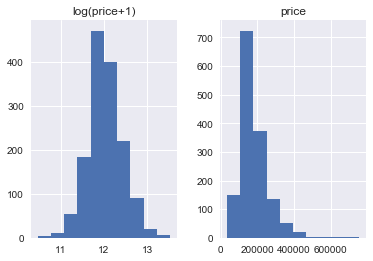

In [6]:
prices=pd.DataFrame({"price":train["SalePrice"],"log(price+1)":np.log1p(train["SalePrice"])})
prices.hist()

In [7]:
#响应变量对数变换
train["SalePrice"]=np.log1p(train["SalePrice"])

#偏度数值特征对数变换
numeric_feats=all_data.select_dtypes(include=[np.number]).columns

skewed_feats=train[numeric_feats].apply(lambda x:skew(x.dropna()))
skewed_feats=skewed_feats[skewed_feats>0.75]
skewed_feats=skewed_feats.index

all_data[skewed_feats]=np.log1p(all_data[skewed_feats])

In [8]:
all_data=pd.get_dummies(all_data)

In [9]:
all_data.shape

(2920, 288)

In [10]:
numeric_feats.shape

(36,)

In [11]:
#缺失值处理
all_data=all_data.fillna(all_data.mean())

In [12]:
X_train=all_data[:train.shape[0]]
X_test=all_data[train.shape[0]:]
y=train.SalePrice

## 模型建立
1.使用正交线性回归模型
2.建立RMSE均方误差函数，评价模型结果

In [13]:
from sklearn.linear_model import Ridge,RidgeCV,ElasticNet,LassoCV,LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse=np.sqrt(-cross_val_score(model,X_train,y,scoring="neg_mean_squared_error",cv=5))
    return rmse

In [14]:
model_ridge=Ridge()

In [15]:
alphas=[0.05,0.1,0.3,1,3,5,10,15,30,50,75]
cv_ridge=[rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

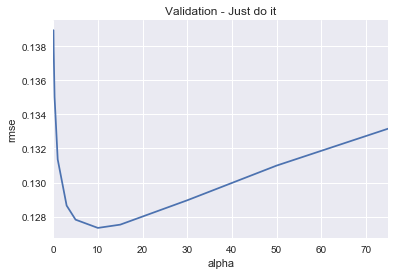

In [16]:
cv_ridge=pd.Series(cv_ridge,index=alphas)
cv_ridge.plot(title="Validation - Just do it")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [17]:
cv_ridge.min()

0.12733664928777003

In [18]:
model_lasso=LassoCV(alphas=[1,0.1,0.001,0.0005]).fit(X_train,y)
rmse_cv(model_lasso).mean()

0.12314592817531518

In [19]:
coef=pd.Series(model_lasso.coef_,index=X_train.columns)

In [20]:
print("Lasso picked "+str(sum(coef != 0))+" variables and eliminated the other "+\
     str(sum(coef==0))+" variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [21]:
imp_coef=pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])

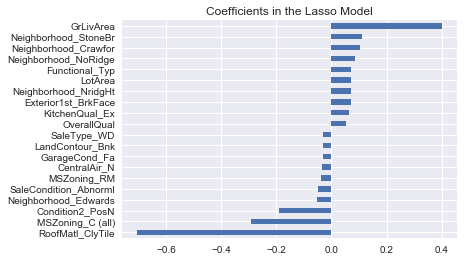

In [22]:
imp_coef.plot(kind="Barh")
plt.title("Coefficients in the Lasso Model")

### 问题：
1.特征选择结果不一定准确，尤其是存在很多共线性特征时。
可以使用boostrapped采样，lasso多次拟合，查看特征选择是否稳定。
2.部分很小的负值特征可能是由于分类特征的不平衡关系引起的。

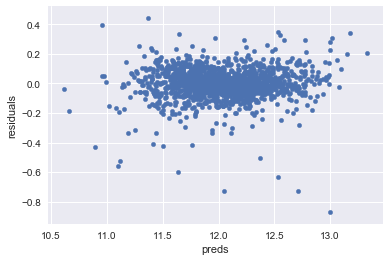

In [23]:
#残差分布
preds=pd.DataFrame({"preds":model_lasso.predict(X_train),"true":y})
preds["residuals"]=preds["true"]-preds["preds"]
preds.plot(x="preds",y="residuals",kind="scatter")

In [24]:
import xgboost as xgb

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
dtrain=xgb.DMatrix(X_train,label=y)
dtest=xgb.DMatrix(X_test)

params={"max_depth":2,"eta":0.1}
model=xgb.cv(params,dtrain,num_boost_round=500,early_stopping_rounds=100)

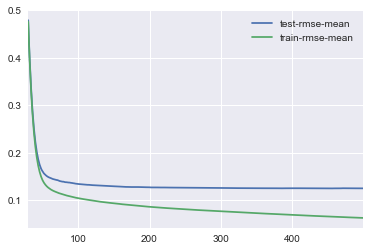

In [26]:
model.loc[30:,["test-rmse-mean","train-rmse-mean"]].plot()

In [27]:
model_xgb=xgb.XGBRegressor(n_estimators=360,max_depth=2,learning_rate=0.1)
model_xgb.fit(X_train,y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [28]:
xgb_preds=np.expm1(model_xgb.predict(X_test))
lass_preds=np.expm1(model_lasso.predict(X_test))

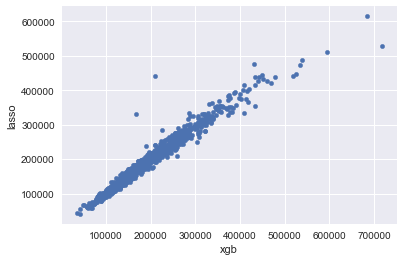

In [29]:
predictions=pd.DataFrame({"xgb":xgb_preds,"lasso":lass_preds})
predictions.plot(x="xgb",y="lasso",kind="scatter")

In [30]:
preds=0.7*lass_preds+0.3*xgb_preds
solution=pd.DataFrame({"id":test.Id,"SalePrice":preds})
solution.to_csv("ridge_sol.csv",index=False)

### 深度学习框架
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train = StandardScaler().fit_transform(X_train)
In [32]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)
In [33]:
X_tr.shape
X_tr

model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")
model.summary()

hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))
pd.Series(model.predict(X_val)[:,0]).hist()